#installing dependencies

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Thu Sep 26 11:41:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

This notebook works fine with transformers 4.12, it is not tested on newer versions

In [ ]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 5.8 MB/s eta 0:00:00
Cloning into 'arabert'...
remote: Enu

Let's download some Arabic text classification datasets

In [ ]:
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!git clone https://github.com/mahmoudnabil/ASTD
!git clone https://github.com/nora-twairesh/AraSenti
!git clone https://github.com/mohamedadaly/LABR
!wget http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
!unzip ArSAS.zip
!unrar x '/content/HARD-Arabic-Dataset/data/unbalanced-reviews.rar'
!unzip '/content/HARD-Arabic-Dataset/data/balanced-reviews.zip'

Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100 (from 1)
Receiving objects: 100% (100/100), 116.36 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Cloning into 'ASTD'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29 (from 1)
Receiving objects: 100% (29/29), 558.04 KiB | 5.37 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Cloning into 'AraSenti'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20 (from 1)
Receiving objects: 100% (20/20), 1.69 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Cloning into 'LABR'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (37/37), 12.32 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (12/12), done.
--2024-09-26 11:44:41--  http://home

#Creating training datasets

In [ ]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner.
It's not necessary to use it with your own data

In [ ]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

You can choose which ever dataset you like or use your own.
At this stage we don't do any preprocessing on the text, this is done later when loading the text.

##HARD - Balanced

In [ ]:
df_HARD = pd.read_excel("/content/combine_claass_df.xlsx")

In [ ]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

df_HARD = pd.read_excel("/content/combine_claass_df.xlsx")

# df_HARD = pd.read_csv("/content/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df_HARD = df_HARD[["combined_text","class"]]  # we are interested in rating and review only
df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_HARD[LABEL_COLUMN].value_counts())
# code rating as +ve if > 3, -ve if less, no 3s in dataset

hard_map = {
    'Hardware Issue': 'Hardware Issue',
    'Network Problem': 'Network Problem',
    'Software Problem':'Software Problem',
    'Power Supply Issue':'Power Supply Issue',
    'Peripheral Issue':'Peripheral Issue'
}


df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
label_list_HARD = [
     'Hardware Issue', 'Network Problem', 'Software Problem', 'Power Supply Issue', 'Peripheral Issue'
]

data_Hard = CustomDataset("HARD", train_HARD, test_HARD, label_list_HARD)
all_datasets.append(data_Hard)

label
Software Problem      328
Power Supply Issue    223
Network Problem       194
Hardware Issue        164
Peripheral Issue       57
Name: count, dtype: int64


##ASTD- Unbalanced

In [ ]:
df_ASTD_UN = pd.read_csv(
    "/content/ASTD/data/Tweets.txt", sep="\t", header=None
)

df_ASTD_UN.columns = [DATA_COLUMN, LABEL_COLUMN]

df_ASTD_UN = df_ASTD_UN[df_ASTD_UN[LABEL_COLUMN]!= 'OBJ']

train_ASTD_UN, test_ASTD_UN = train_test_split(
    df_ASTD_UN, test_size=0.2, random_state=42
)

label_list_ASTD_UN = list(df_ASTD_UN[LABEL_COLUMN].unique())
print(label_list_ASTD_UN)
print(df_ASTD_UN[LABEL_COLUMN].value_counts())

data_ASTD_UN = CustomDataset(
    "ASTD-Unbalanced", train_ASTD_UN, test_ASTD_UN, label_list_ASTD_UN
)

all_datasets.append(data_ASTD_UN)

['POS', 'NEG', 'NEUTRAL']
NEG        1642
NEUTRAL     805
POS         777
Name: label, dtype: int64


##ASTD-Dahou-Balanced

In [ ]:
df_ASTD_B = pd.read_csv(
    "/content/drive/My Drive/Datasets/Dahou/data_csv_balanced/ASTD-balanced-not-linked.csv",
    sep=",",
    header=0,
)

df_ASTD_B.columns = [DATA_COLUMN, LABEL_COLUMN]

df_ASTD_B[LABEL_COLUMN] = df_ASTD_B[LABEL_COLUMN].apply(lambda x: 'NEG' if (x == -1) else 'POS')

train_ASTD_B, test_ASTD_B = train_test_split(df_ASTD_B, test_size=0.2, random_state=42)
label_list_ASTD_B = list(df_ASTD_B[LABEL_COLUMN].unique())

data_ASTD_B = CustomDataset(
    "ASTD-Dahou-Balanced", train_ASTD_B, test_ASTD_B, label_list_ASTD_B
)
all_datasets.append(data_ASTD_B)

##Arsentv-lev

You need to manualy get the ArSenTD-LEV.tsv before running this

In [ ]:
# df_ArSenTD = pd.read_csv(
#     "/content/drive/MyDrive/Datasets/ArSenTD-LEV/ArSenTD-LEV.tsv", sep="\t", header=0
# )

# df_ArSenTD = df_ArSenTD[['Tweet','Sentiment']]

# df_ArSenTD.columns = [DATA_COLUMN, LABEL_COLUMN]

# print(df_ArSenTD[LABEL_COLUMN].value_counts())
# label_list_ArSenTD = list(df_ArSenTD[LABEL_COLUMN].unique())

# train_ArSenTD, test_ArSenTD = train_test_split(
#     df_ArSenTD, test_size=0.2, random_state=42
# )

# data_ArSenTD = CustomDataset("ArSenTD-LEV", train_ArSenTD, test_ArSenTD, label_list_ArSenTD)
# all_datasets.append(data_ArSenTD)

##AJGT

In [ ]:
df_AJGT = pd.read_excel("/content/drive/My Drive/Datasets/Ajgt/AJGT.xlsx", header=0)

df_AJGT = df_AJGT[["Feed", "Sentiment"]]
df_AJGT.columns = [DATA_COLUMN, LABEL_COLUMN]



train_AJGT, test_AJGT = train_test_split(df_AJGT, test_size=0.2, random_state=42)

print(df_AJGT[LABEL_COLUMN].value_counts())
label_list_AJGT = list(df_AJGT[LABEL_COLUMN].unique())

data_AJGT = CustomDataset("AJGT", train_AJGT, test_AJGT, label_list_AJGT)
all_datasets.append(data_AJGT)

Positive    900
Negative    900
Name: label, dtype: int64


##LABR-Unbalanced

In [ ]:
#@title
%%writefile labr.py
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 10 16:27:03 2013

@author: Mohamed Aly <mohamed@mohamedaly.info>
"""

import codecs
import numpy as np
import pandas as pd
import re

class LABR:
    def __init__(self):
        self.REVIEWS_PATH = "LABR/data/"
        self.RAW_REVIEWS_FILE = "raw_reviews.tsv"
        self.DELETED_REVIEWS_FILE = "deleted_reviews.tsv"
        self.CLEAN_REVIEWS_FILE = "reviews.tsv"

    # Copied from the PyArabic package.
    def arabicrange(self):
        """return a list of arabic characteres .
        Return a list of characteres between \u060c to \u0652
        @return: list of arabic characteres.
        @rtype: unicode;
        """
        mylist=[];
        for i in range(0x0600, 0x00653):
            try :
                mylist.append(unichr(i));
            except ValueError:
                pass;
        return mylist;

    # cleans a single review
    def clean_raw_review(self, body):
         # patterns to remove first
        pat = [\
            (u'http[s]?://[a-zA-Z0-9_\-./~\?=%&]+', u''),               # remove links
            (u'www[a-zA-Z0-9_\-?=%&/.~]+', u''),
#            u'\n+': u' ',                     # remove newlines
            (u'<br />', u' '),                  # remove html line breaks
            (u'</?[^>]+>', u' '),              # remove html markup
#            u'http': u'',
            (u'[a-zA-Z]+\.org', u''),
            (u'[a-zA-Z]+\.com', u''),
            (u'://', u''),
            (u'&[^;]+;', u' '),
            (u':D', u':)'),
#            (u'[0-9/]+', u''),
#            u'[a-zA-Z.]+': u'',
#            u'[^0-9' + u''.join(self.arabicrange()) + \
#                u"!.,;:$%&*%'#(){}~`\[\]/\\\\\"" + \
#                u'\s^><\-_\u201D\u00AB=\u2026]+': u'',          # remove latin characters
            (u'\s+', u' '),                     # remove spaces
            (u'\.+', u'.'),                     # multiple dots
            (u'[\u201C\u201D]', u'"'),          #“
            (u'[\u2665\u2764]', u''),           # heart symbol
            (u'[\u00BB\u00AB]', u'"'),
            (u'\u2013', u'-'),                # dash
        ]

        # patterns that disqualify a review
        remove_if_there = [\
            (u'[^0-9' + u''.join(self.arabicrange()) + \
                u"!.,;:$%&*%'#(){}~`\[\]/\\\\\"" + \
                u'\s\^><\-_\u201D\u00AB=\u2026+|' + \
                u'\u0660-\u066D\u201C\u201D' + \
                u'\ufefb\ufef7\ufef5\ufef9]+', u''),                   # non arabic characters
        ]

        # patterns that disqualify if empty after removing
        remove_if_empty_after = [\
            (u'[0-9a-zA-Z\-_]', u' '),             #alpha-numeric
            (u'[0-9' + u".,!;:$%&*%'#(){}~`\[\]/\\\\\"" + \
                u'\s\^><`\-=_+]+', u''),                  # remove just punctuation
            (u'\s+', u' '),                     # remove spaces
        ]

        # remove again
        # patterns to remove
        pat2 = [\
#            u'[^0-9' + u''.join(self.arabicrange()) + \
#                u"!.,;:$%&*%'#(){}~`\[\]/\\\\\"" + \
#                u'\s^><\-_\u201D\u00AB=\u2026]+': u'',          # remove latin characters
        ]

        skip = False

        # if empty body, skip
        if body == u'': skip = True

        # do some subsitutions
        for k,v in pat:
            body = re.sub(k, v, body)

        # remove if exist
        for k,v in remove_if_there:
            if re.search(k, body):
                skip = True

        # remove if empty after replacing
        for k,v in remove_if_empty_after:
            temp = re.sub(k, v, body)
            if temp == u" " or temp == u"":
                skip = True

        # do some more subsitutions
        if not skip:
            for k,v in pat2:
                body = re.sub(k, v, body)

        # if empty string, skip
        if body == u'' or body == u' ':
            skip = True

        if not skip:
            return body
        else:
            return u""

    # Read raw reviews from file and clean and write into clean_reviews
    def clean_raw_reviews(self):
        # input file
        in_file = codecs.open(self.REVIEWS_PATH + self.RAW_REVIEWS_FILE,
                              'r', encoding="utf-8")
        reviews = in_file.readlines()

        # Output file: rating<tab>content
        out_file = open(self.REVIEWS_PATH + self.CLEAN_REVIEWS_FILE,
                        'w', buffering = 100)
        deleted_file = open(self.REVIEWS_PATH + self.DELETED_REVIEWS_FILE,
                            'w', buffering = 100)

        counter = 1
        for i in xrange(0, len(reviews)):
            review = reviews[i]
            skip = False

#           # If line starts with #, then skip
#            if review[0] == u"#": continue

            # split by <tab>
            parts = review.split(u"\t")

            # rating is first part and body is last part
            rating = parts[0]
            review_id = parts[1]
            user_id = parts[2]
            book_id = parts[3]
            body = parts[4].strip()

            # clean body
            body = self.clean_raw_review(body)
            if body == u"": skip = True

            if i % 5000 == 0:
                print("review %d:" % (i))

            # write output
            line = u"%s\t%s\t%s\t%s\t%s\n" % (rating, review_id, user_id,
                                              book_id, body)
            if not skip:
                out_file.write(line.encode('utf-8'))
                counter += 1
            else:
                deleted_file.write(line.encode('utf-8'))

    # Read the reviews file. Returns a tuple containing these lists:
    #   rating: the rating 1 -> 5
    #   review_id: the id of the review
    #   user_id: the id of the user
    #   book_id: the id of the book
    #   body: the text of the review
    def read_review_file(self, file_name):
        reviews = codecs.open(file_name, 'r', 'utf-8').readlines()

        # remove comment lines and newlines
        reviews = [r.strip() for r in reviews if r[0] != u'#']

        # parse
        rating = list()
        review_id = list()
        user_id = list()
        book_id = list()
        body = list()
        for review in reviews:
            # split by <tab>
            parts = review.split(u"\t")

            # rating is first part and body is last part
            rating.append(int(parts[0]))
            review_id.append(parts[1])
            user_id.append(parts[2])
            book_id.append(parts[3])
            if len(parts) > 4:
                body.append(parts[4])
            else:
                body.append(u"")

        return (rating, review_id, user_id, book_id, body)

    # Writes reviews to a file
    def write_review_file(self, file_name, rating, review_id, user_id,
                          book_id, body):

        lines = list()
        # loop
        for i in xrange(len(rating)):
            line = u"%s\t%s\t%s\t%s\t%s\n" % (rating[i], review_id[i],
                                              user_id[i], book_id[i],
                                              body[i])
            lines.append(line)

        open(file_name, 'w').write(u''.join(lines).encode('utf-8'))

    def read_clean_reviews(self):
        return self.read_review_file(self.REVIEWS_PATH +
                                     self.CLEAN_REVIEWS_FILE)

    def read_raw_reviews(self):
        return self.read_review_file(self.REVIEWS_PATH + self.RAW_REVIEWS_FILE)

    # Splits the dataset into a training/test sets in the setting of using 5
    # classes (predicting the rating value from 1 to 5)
    def split_train_test_5class(self, rating, percent_test,
                                balanced = "unbalanced"):
        np.random.seed(1234)

        num_reviews = len(rating)
        review_ids = np.arange(0, num_reviews)

        if balanced == "unbalanced":
            ntest = np.floor(num_reviews * percent_test)
            np.random.shuffle(review_ids)

            test_ids = review_ids[:ntest]
            train_ids = review_ids[ntest:]

        elif balanced == "balanced":
            (sizes, bins) = np.histogram(rating, [1, 2, 3, 4, 5, 6])
            min_size = np.min(sizes)
            print(min_size)

            # sample review ids equally among classes
            test_ids = np.zeros((0,), dtype="int32")
            train_ids = np.zeros((0,), dtype="int32")
            rating = np.array(rating)
            ntest = np.floor(min_size * percent_test)
            for c in range(1, 6):
                cids = review_ids[np.nonzero(rating == c)]
                np.random.shuffle(cids)

                test_ids = np.r_[test_ids, cids[:ntest]]
                train_ids = np.r_[train_ids, cids[ntest:min_size]]

        train_file = self.REVIEWS_PATH + "5class-" + balanced+ "-train.txt"
        test_file = self.REVIEWS_PATH + "5class-" + balanced+ "-test.txt"

        open(train_file, 'w').write('\n'.join(map(str, train_ids)))
        open(test_file, 'w').write('\n'.join(map(str, test_ids)))

        return (train_ids, test_ids)

    # Splits the dataset into a training/test sets in the setting of using 2
    # classes (predicting the polarity of the review where ratings 1 & 2
    # are considered negative, ratings 4 & 5 are positive, and rating 3 is
    # ignored)
    def split_train_test_2class(self, rating, percent_test,
                                balanced = "unbalanced"):
        np.random.seed(1234)

        rating = np.array(rating, dtype='int32')
        # length
        num_reviews = len(rating)
        review_ids = np.arange(0, num_reviews)

        # convert to binary, with ratings [1, 2] --> neg and [4, 5] --> pos
        rating[rating == 2] = 1
        rating[rating == 4] = 5

        ids = (rating == 1) + (rating == 5)
        review_ids = review_ids[ids]
        rating = rating[ids]
        rating[rating == 1] = 0
        rating[rating == 5] = 1

        # get length after filtering
        num_reviews = rating.shape[0]

        if balanced == "unbalanced":
            ntest = np.floor(num_reviews * percent_test)
            np.random.shuffle(review_ids)

            test_ids = review_ids[:ntest]
            train_ids = review_ids[ntest:]

        elif balanced == "balanced":
            (sizes, bins) = np.histogram(rating, [0, 1, 2])
            min_size = np.min(sizes)
            print(min_size)

            # sample review ids equally among classes
            test_ids = np.zeros((0,), dtype="int32")
            train_ids = np.zeros((0,), dtype="int32")
            rating = np.array(rating)
            ntest = np.floor(min_size * percent_test)
            for c in [0, 1]:
                cids = review_ids[np.nonzero(rating == c)]
                np.random.shuffle(cids)

                test_ids = np.r_[test_ids, cids[:ntest]]
                train_ids = np.r_[train_ids, cids[ntest:min_size]]

        train_file = self.REVIEWS_PATH + "2class-" + balanced+ "-train.txt"
        test_file = self.REVIEWS_PATH + "2class-" + balanced+ "-test.txt"

        open(train_file, 'w').write('\n'.join(map(str, train_ids)))
        open(test_file, 'w').write('\n'.join(map(str, test_ids)))

        return (train_ids, test_ids)

    # Reads a training or test file. The file contains the indices of the
    # reviews from the clean reviews file.
    def read_train_test_file(self, file_name):
        ins = open(file_name).readlines()
        ins = [int(i.strip()) for i in ins]

        return ins

    # A helpter function.
    def set_binary_klass(self, ar):
        ar[(ar == 1) + (ar == 2)] = 0
        ar[(ar == 4) + (ar == 5)] = 1

    # Returns (train_x, train_y, test_x, test_y)
    # where x is the review body and y is the rating (1->5 or 0->1)
    def get_train_test(self, klass = "2", balanced = "balanced"):
        (rating, a, b, c, body) = self.read_clean_reviews()
        rating = np.array(rating)
        body = pd.Series(body)

        train_file = (self.REVIEWS_PATH + klass + "class-" +
            balanced+ "-train.txt")
        test_file = (self.REVIEWS_PATH + klass + "class-" +
            balanced+ "-test.txt")

        train_ids = self.read_train_test_file(train_file)
        test_ids = self.read_train_test_file(test_file)

        train_y = rating[train_ids]
        test_y = rating[test_ids]
        train_x = body[train_ids]
        test_x = body[test_ids]

        if klass == "2":
            self.set_binary_klass(train_y)
            self.set_binary_klass(test_y)

        return (train_x, train_y, test_x, test_y)


Overwriting labr.py


In [ ]:
from labr import LABR

labr_helper = LABR()

(d_train, y_train, d_test, y_test) = labr_helper.get_train_test(
    klass="2", balanced="unbalanced"
)

train_LABR_B_U = pd.DataFrame({DATA_COLUMN: d_train, LABEL_COLUMN: y_train})
test_LABR_B_U = pd.DataFrame({DATA_COLUMN: d_test, LABEL_COLUMN: y_test})

train_LABR_B_U[LABEL_COLUMN] = train_LABR_B_U[LABEL_COLUMN].apply(lambda x: 'NEG' if (x == 0) else 'POS')
test_LABR_B_U[LABEL_COLUMN] = test_LABR_B_U[LABEL_COLUMN].apply(lambda x: 'NEG' if (x == 0) else 'POS')

print(train_LABR_B_U[LABEL_COLUMN].value_counts() + test_LABR_B_U[LABEL_COLUMN].value_counts())
label_list_LABR_B_U = list(test_LABR_B_U[LABEL_COLUMN].unique())

data_LABR_B_U = CustomDataset(
    "LABR-UN-Binary", train_LABR_B_U, test_LABR_B_U, label_list_LABR_B_U
)
all_datasets.append(data_LABR_B_U)

POS    42832
NEG     8224
Name: label, dtype: int64


In [ ]:
for x in all_datasets:
  print(x.name)

HARD
ASTD-Unbalanced
ASTD-Dahou-Balanced
AJGT
LABR-UN-Binary


## ArSAS

In [ ]:
df_ArSAS = pd.read_csv("/content/ArSAS..txt", sep="\t",encoding='utf-8')
df_ArSAS = df_ArSAS[["Tweet_text","Sentiment_label"]]  # we are interested in rating and review only
df_ArSAS.columns = [DATA_COLUMN, LABEL_COLUMN]
print("Total length: ", len(df_ArSAS))
print(df_ArSAS[LABEL_COLUMN].value_counts())

label_list_ArSAS = list(df_ArSAS[LABEL_COLUMN].unique())
print(label_list_ArSAS)

train_ArSAS, test_ArSAS = train_test_split(df_ArSAS, test_size=0.2, random_state=42)
print("Training length: ", len(train_ArSAS))
print("Testing length: ", len(test_ArSAS))
data_ArSAS = CustomDataset("ArSAS", train_ArSAS, test_ArSAS, label_list_ArSAS)
all_datasets.append(data_ArSAS)

Total length:  19897
Negative    7384
Neutral     6894
Positive    4400
Mixed       1219
Name: label, dtype: int64
['Positive', 'Negative', 'Neutral', 'Mixed']
Training length:  15917
Testing length:  3980


#Trainer

Start the training procedure

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [ ]:
for x in all_datasets:
  print(x.name)

HARD
ASTD-Unbalanced
ASTD-Dahou-Balanced
AJGT
LABR-UN-Binary
ArSAS


In [ ]:
# select a dataset
dataset_name = 'HARD'
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
# model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects
model_name ="CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry"

In [ ]:
path = "/content/combine_claass_df.xlsx"
df = pd.read_excel(path)

In [ ]:
import copy
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


Create and apply preprocessing using the AraBERT processor

In [ ]:
from arabert import ArabertPreprocessor

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))

In [ ]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['نفيد سعادتكم بتعطل طابعه بقسم الجوده العمل برجاء الاطلاع والتوجيه علي يلزم لحل المشكله ولكم جزيل الشكر مدير تقنيه المعلومات بمستشفي السليل منصور عبدالله الحابي تنبيه باخلاء المسءوليه ومرفقاتها معده لاستخدام اليه بالرساله فقط تحتوي سريه محميه قانونيا تكن الشخص فانه يمنع منعا باتا عرض نشر استخدام مصرح للمحتوي اخطار الالكتروني واتلاف النسخ الموجوده لديك تعد التصريحات الاراء بالمرسل تمثل تتحمل مسءوليه الاضرار الناتجه فيروسات تحملها',
 'رقم التواصل ارسلت ال في الساعه كتب كتبت الكرام ارسال فريق العمل جاري العمل فحص الاجهزه شكرا السلام عليكم ارجو توجيه الدعم الفني لديكم بربط اجهزه المستشفي والمراكز الصحيه وتسميتها الوارد الينا التجمع وذلك لعدم وجود موظف دعم فني مقيم لدينا وشكرا المنطقه الوسطي مستشفي نفي مدير الالكترونيه بالمستشفي فواز سالم الحصني ارسلت ال تنبيه باخلاء المسءوليه ومرفقاتها معده لاستخدام اليه بالرساله فقط تحتوي سريه محميه قانونيا تكن الشخص فانه يمنع منعا باتا عرض نشر استخدام مصرح للمحتوي اخطار الالكتروني واتلاف النسخ الموجوده لديك تعد التصريحات الاراء بالمرسل تمثل تتحمل مسءولي

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry")
tok = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.05k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training Sentence Lengths: 


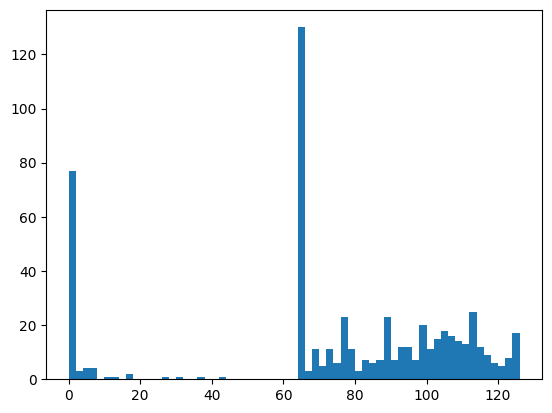

Testing Sentence Lengths: 


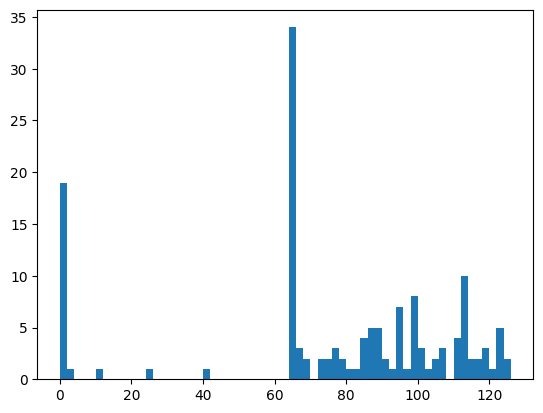

In [ ]:
import matplotlib.pyplot as plt
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [ ]:
max_len = 128

In [ ]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  46
Truncated testing sequences:  46


8 out of ~4000 for testing isn't bad

Now let's create a classification dataset to load the data

In [ ]:
from torch.utils.data import Dataset
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'Hardware Issue': 0, 'Network Problem': 1, 'Software Problem': 2, 'Power Supply Issue': 3, 'Peripheral Issue': 4}


Check the dataset output

In [ ]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class InputFeatures(object): # Add this class definition
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]]) # Now this line should work

In [ ]:
print(next(iter(train_dataset)))

Create a function that return a pretrained model ready to do classification

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map), ignore_mismatched_sizes=True)
    # Added ignore_mismatched_sizes=True to handle the mismatch in the number of labels.

Define whatever metric you want here

In [ ]:
!pip install torchmetrics

In [ ]:
n_classes = len(label_map)

In [ ]:
# from torchmetrics import F1Score
# def compute_metrics(p): #p should be of type EvalPrediction
#   preds = np.argmax(p.predictions, axis=1)
#   assert len(preds) == len(p.label_ids)
#   #print(classification_report(p.label_ids,preds))
#   #print(confusion_matrix(p.label_ids,preds))
#   f1_score = F1Score(task="multiclass", num_classes=n_classes, average='macro') # Create an F1Score instance with the 'multiclass' task
#   macro_f1 = f1_score(preds, p.label_ids) # Calculate the F1 score by passing the predictions and labels and store it in a variable
#   # macro_f1 = F1Score(p.label_ids,preds,average='macro')
#   #macro_precision = precision_score(p.label_ids,preds,average='macro')
#   #macro_recall = recall_score(p.label_ids,preds,average='macro')
#   acc = accuracy_score(p.label_ids,preds)
#   return {
#       'macro_f1' : macro_f1,
#       'accuracy': acc
#   }
#   # "CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry"

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [ ]:
from transformers import TrainingArguments, Trainer
import random
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 10,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer

In [ ]:
!pip install --upgrade torchmetrics
!pip install --upgrade torch

from transformers import AutoModelForSequenceClassification
import torch
from torchmetrics import F1Score, Precision, Recall, Accuracy

# Convert NumPy arrays to PyTorch tensors and calculate metrics
def compute_metrics(p):
  preds = torch.from_numpy(p.predictions)
  labels = torch.from_numpy(p.label_ids)
  preds = torch.argmax(preds, axis=1)

  f1_score = F1Score(task="multiclass", num_classes=n_classes, average='macro')
  macro_f1 = f1_score(preds, labels)

  precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
  macro_precision = precision(preds, labels)

  recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
  macro_recall = recall(preds, labels)

  accuracy = Accuracy(task="multiclass", num_classes=n_classes)
  acc = accuracy(preds, labels)

  return {'macro_f1' : macro_f1, 'macro_precision': macro_precision, 'macro_recall': macro_recall, 'accuracy': acc}

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([23, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([23]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,0.961537,0.533845,0.690942,0.536550,0.695876
2,No log,0.416179,0.718888,0.713822,0.729676,0.876289
4,No log,0.317929,0.866053,0.897036,0.861965,0.881443
6,No log,0.259281,0.899860,0.882874,0.926959,0.902062
8,No log,0.260063,0.909446,0.893069,0.935569,0.912371
9,No log,0.211095,0.900571,0.884024,0.926959,0.902062


TrainOutput(global_step=240, training_loss=0.3965223948160807, metrics={'train_runtime': 297.2326, 'train_samples_per_second': 25.973, 'train_steps_per_second': 0.807, 'total_flos': 498082643684352.0, 'train_loss': 0.3965223948160807, 'epoch': 9.795918367346939})

Save the model, the tokenizer and the config

In [ ]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

{0: 'Hardware Issue', 1: 'Network Problem', 2: 'Software Problem', 3: 'Power Supply Issue', 4: 'Peripheral Issue'}


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [ ]:
#copy the model to drive
!cp output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory 'output_dir'


## predict using the saved model

In [ ]:
from transformers import pipeline

In [ ]:
# initialize pipline
pipe = pipeline("text-classification", model="output_dir", device=0, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
pipe("نفيد سعادتكم بوجود مشكله جهاز عياده العظام الدخول وفتح الجهاز بيوزر موظف نوع الجهاز رقم الجهاز برجاء الاطلاع وتوجيه المختصين ليدكم لحل المشكله ولكم جزيل الشكر مدير تقنيه المعلومات بمستشفي السليل العام منصور عبدالله الحابي تنبيه باخلاء المسءوليه ومرفقاتها معده لاستخدام اليه بالرساله فقط تحتوي سريه محميه قانونيا تكن الشخص فانه يمنع منعا باتا عرض نشر استخدام مصرح للمحتوي اخطار الالكتروني واتلاف النسخ الموجوده لديك تعد التصريحات الاراء بالمرسل تمثل تتحمل مسءوليه الاضرار الناتجه فيروسات تحملها")

[[{'label': 'Hardware Issue', 'score': 0.013072000816464424},
  {'label': 'Network Problem', 'score': 0.009265456348657608},
  {'label': 'Software Problem', 'score': 0.01583610288798809},
  {'label': 'Power Supply Issue', 'score': 0.9559705257415771},
  {'label': 'Peripheral Issue', 'score': 0.005855914205312729}]]

# K-fold

This section is bit more advanced.

We will divide the training set into K-folds and train model with cross-validation to check for the best hyper-parameters before check the performance on the test set.

Alternatively, you can combine the training and testing set if you are participating in a competition, then ensemble the output models

In [ ]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [ ]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

Defing the number of Stratified kfold splits

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

Train using cross validation and save the best model at each fold

In [ ]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")

  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)

  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)

  training_args = TrainingArguments(
    output_dir= f"./train_{fold_num}",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*"

  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,1.210287,0.432500,0.473113,0.469534,0.619355
2,No log,1.118647,0.438564,0.474048,0.475090,0.625806


{'eval_loss': 1.1186468601226807, 'eval_macro_f1': 0.438563734292984, 'eval_macro_precision': 0.47404760122299194, 'eval_macro_recall': 0.4750896096229553, 'eval_accuracy': 0.625806450843811, 'eval_runtime': 1.169, 'eval_samples_per_second': 132.587, 'eval_steps_per_second': 1.711, 'epoch': 2.0}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  1  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,1.230110,0.412295,0.469545,0.452867,0.600000
2,No log,1.153774,0.405930,0.459150,0.449021,0.593548


{'eval_loss': 1.2301099300384521, 'eval_macro_f1': 0.41229528188705444, 'eval_macro_precision': 0.4695454239845276, 'eval_macro_recall': 0.45286738872528076, 'eval_accuracy': 0.6000000238418579, 'eval_runtime': 1.1477, 'eval_samples_per_second': 135.053, 'eval_steps_per_second': 1.743, 'epoch': 2.0}
**************************Starting Fold Num:  2  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,1.201231,0.415281,0.485840,0.448571,0.597403
2,No log,1.121021,0.498722,0.651748,0.506209,0.642857


{'eval_loss': 1.1210212707519531, 'eval_macro_f1': 0.4987221956253052, 'eval_macro_precision': 0.6517476439476013, 'eval_macro_recall': 0.5062094330787659, 'eval_accuracy': 0.6428571343421936, 'eval_runtime': 1.227, 'eval_samples_per_second': 125.514, 'eval_steps_per_second': 1.63, 'epoch': 2.0}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  3  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,1.167431,0.465789,0.492593,0.493333,0.649351
2,No log,1.098101,0.471160,0.483922,0.505714,0.662338


{'eval_loss': 1.0981006622314453, 'eval_macro_f1': 0.4711601436138153, 'eval_macro_precision': 0.4839215874671936, 'eval_macro_recall': 0.5057142972946167, 'eval_accuracy': 0.6623376607894897, 'eval_runtime': 1.1457, 'eval_samples_per_second': 134.415, 'eval_steps_per_second': 1.746, 'epoch': 2.0}
**************************Starting Fold Num:  4  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,1.192291,0.470204,0.498113,0.500952,0.649351
2,No log,1.105973,0.474549,0.499048,0.507619,0.655844


{'eval_loss': 1.1059727668762207, 'eval_macro_f1': 0.4745487868785858, 'eval_macro_precision': 0.4990476369857788, 'eval_macro_recall': 0.5076190233230591, 'eval_accuracy': 0.6558441519737244, 'eval_runtime': 1.3925, 'eval_samples_per_second': 110.593, 'eval_steps_per_second': 1.436, 'epoch': 2.0}


In [ ]:
# prompt: make visulization using ployly express for all_results

import plotly.express as px

# Extract the relevant metrics from all_results
eval_macro_f1_scores = [result['eval_macro_f1'] for result in all_results]
eval_accuracy_scores = [result['eval_accuracy'] for result in all_results]
eval_macro_precision_scores = [result['eval_macro_precision'] for result in all_results]
eval_macro_recall_scores = [result['eval_macro_recall'] for result in all_results]
fold_numbers = list(range(len(all_results)))


# Create a DataFrame for the visualization
df_results = pd.DataFrame({
    'Fold': fold_numbers,
    'Macro F1': eval_macro_f1_scores,
    'Accuracy': eval_accuracy_scores,
    'Macro Precision': eval_macro_precision_scores,
    'Macro Recall': eval_macro_recall_scores
})

# Create a line plot using Plotly Express
fig = px.line(df_results, x='Fold', y=['Macro F1', 'Accuracy', 'Macro Precision', 'Macro Recall'],
              title='Cross-Validation Performance Across Folds')
fig.update_layout(xaxis_title='Fold Number', yaxis_title='Metric Score')
fig.show()


In [ ]:
all_results

[{'eval_loss': 1.1186468601226807,
  'eval_macro_f1': 0.438563734292984,
  'eval_macro_precision': 0.47404760122299194,
  'eval_macro_recall': 0.4750896096229553,
  'eval_accuracy': 0.625806450843811,
  'eval_runtime': 1.169,
  'eval_samples_per_second': 132.587,
  'eval_steps_per_second': 1.711,
  'epoch': 2.0},
 {'eval_loss': 1.2301099300384521,
  'eval_macro_f1': 0.41229528188705444,
  'eval_macro_precision': 0.4695454239845276,
  'eval_macro_recall': 0.45286738872528076,
  'eval_accuracy': 0.6000000238418579,
  'eval_runtime': 1.1477,
  'eval_samples_per_second': 135.053,
  'eval_steps_per_second': 1.743,
  'epoch': 2.0},
 {'eval_loss': 1.1210212707519531,
  'eval_macro_f1': 0.4987221956253052,
  'eval_macro_precision': 0.6517476439476013,
  'eval_macro_recall': 0.5062094330787659,
  'eval_accuracy': 0.6428571343421936,
  'eval_runtime': 1.227,
  'eval_samples_per_second': 125.514,
  'eval_steps_per_second': 1.63,
  'epoch': 2.0},
 {'eval_loss': 1.0981006622314453,
  'eval_macro_f1

In [ ]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.45905802845954896

After checking for the best hyper parameters you should use the regular training section and retrain the model with the parameters that you had here.

Or Ensemble the models together.

## Ensemble all the cross validation models

In [ ]:
from transformers import pipeline
import more_itertools

In [ ]:
inv_label_map = { v:k for k, v in label_map.items()}

Load some file which has text that we need to run inference on.
I will use the test set for that

In [ ]:
# pred_df = prediction['Text']
# pred_df = pred_df.apply(lambda x:   arabic_prep.preprocess(x))

pred_df = selected_dataset.test[DATA_COLUMN]

In [ ]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("text-classification", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-97-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-97-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-97-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-97-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-97-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

In [ ]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [ ]:
cross_val_df['preds'] = final_labels
cross_val_df['class'] = final_scores

In [ ]:
cross_val_df['preds'].value_counts()

,count
preds,
Software Problem,132
Network Problem,41
Power Supply Issue,20
Hardware Issue,1


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

                    precision    recall  f1-score   support

    Hardware Issue       0.00      0.00      0.00        29
   Network Problem       0.93      0.90      0.92        42
  Peripheral Issue       0.00      0.00      0.00        11
Power Supply Issue       1.00      0.43      0.61        46
  Software Problem       0.50      1.00      0.67        66

          accuracy                           0.64       194
         macro avg       0.49      0.47      0.44       194
      weighted avg       0.61      0.64      0.57       194



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU

def calculate_rouge_and_bleu(predictions, references):
    """Calculates ROUGE and BLEU scores for a list of predictions and references.

    Args:
        predictions: A list of predicted strings.
        references: A list of reference strings.
    """

    # Initialize the scorers
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    bleu_scorer = BLEU(effective_order=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu_scores = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score once for the entire corpus, not individually
    bleu_score = bleu_scorer.corpus_score(predictions, [references]).score

    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    return avg_rouge1, avg_rouge2, avg_rougeL, bleu_score

# Replace 'selected_dataset.test[DATA_COLUMN]' with your actual predictions and 'selected_dataset.test[LABEL_COLUMN]' with your true labels.
predictions = cross_val_df['preds'].tolist()
references = selected_dataset.test[LABEL_COLUMN].tolist()

# Ensure predictions and references are strings
predictions = [str(p) for p in predictions]
references = [str(r) for r in references]

avg_rouge1, avg_rouge2, avg_rougeL, avg_bleu = calculate_rouge_and_bleu(predictions, references)

print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")
print(f"Average BLEU: {avg_bleu}")

Average ROUGE-1: 0.6515463917525773
Average ROUGE-2: 0.6391752577319587
Average ROUGE-L: 0.6515463917525773
Average BLEU: 71.91311572088277
